# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from collections import defaultdict
import numpy as np
import seaborn as sns
from pyteomics.parser import cleave
import sys
sys.path.insert(1, '../scripts/')
import utils


In [2]:

# Define the settings for the plots
rc = {'figure.figsize':(15,10),
      'axes.facecolor':'white',
      'figure.facecolor':'white',
      'axes.grid' : False,
      'font.size' : 20}

# A. Properties of the hybrid database

Text(-1.0219680198137389, 0.4069169036523128, 'GENCODE')
Text(-0.5574371017165848, 0.22195467471944333, '91127')
Text(1.0219680388628927, -0.4069168558105368, 'novel')
Text(0.5574371121070323, -0.22195464862392916, '12499')


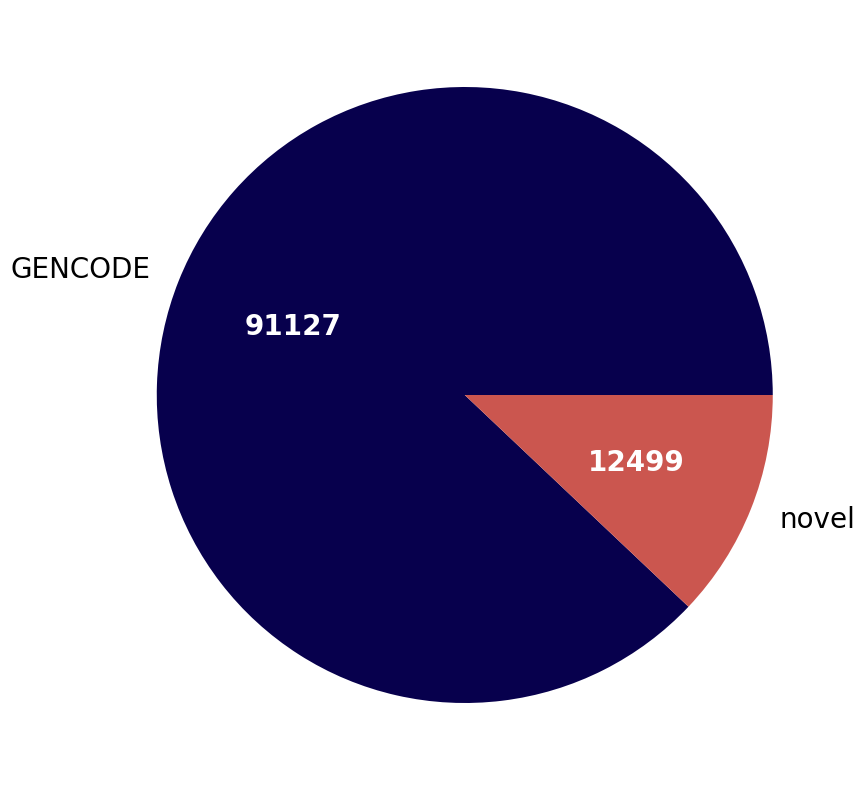

In [3]:
def absolute_value(val):
    '''Function to return the absolute value for piechart labels'''
    a  = np.round(val/100.*database_df.source.value_counts().sum())
    return int(a)

database_dict = defaultdict(list)

# Load the fasta file into a dictionary
with open('../data/proteomics/isoquant/hnr_50_hybrid.fasta') as fastafile:
  for record in SeqIO.parse(fastafile,"fasta"):
    ident = record.id
    sequence = str(record.seq)
    database_dict['id'].append(ident)
    database_dict['sequence'].append(sequence)

database_df = pd.DataFrame.from_dict(database_dict)

# Use the id of the sequence to add a source (GENCODE or novel)
database_df['source']=database_df['id'].apply(lambda x: x.split('|',1)[0])
database_df['source']=database_df['source'].str.replace('gc','Gencode')
database_df['source']=database_df['source'].str.replace('pb','Novel')

# Create the pieplot
plt.rcParams.update(rc)
ax = database_df.source.value_counts().plot.pie(autopct=absolute_value, colors = ['#07004D', '#cb564f'], labels = ['GENCODE', 'novel'])
# Use white text for the numberes and black text for the labels
for text, color, weight in zip(ax.texts, ['black', 'white', 'black', 'white'], ['normal', 'bold', 'normal', 'bold']):
    print(text)
    text.set_color(color)
    text.set_weight(weight)

ax.axes.get_yaxis().set_visible(False)
plt.savefig('plots/database.svg', dpi = 300,  bbox_inches='tight')
plt.show()


# B. In-silico digestion of the database

Text(-0.7359705363917131, 0.8175251491931574, 'GENCODE')
Text(-0.4014384743954798, 0.4459228086508131, '75989')
Text(0.6955296756214492, -0.852196262799786, 'multi-mapping')
Text(0.379379823066245, -0.4648343251635195, '26039')
Text(1.0987101998601938, -0.05325313815328977, 'novel')
Text(0.5992964726510147, -0.02904716626543078, '1597')


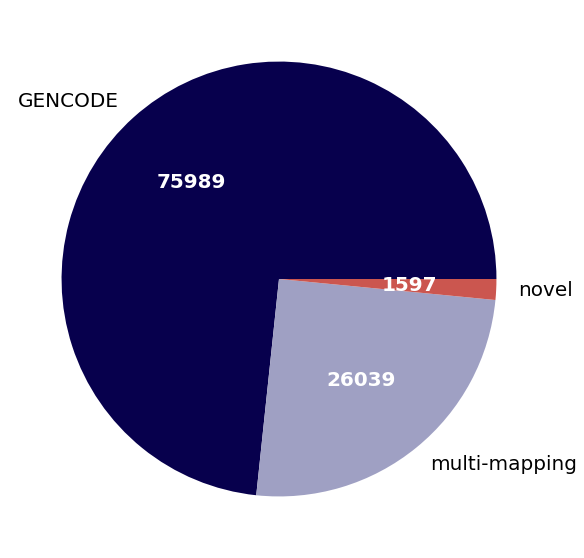

In [5]:
# Perform in-silico digestion of the sequences in the database with trypsin
database_df['peptides_trypsin']=database_df.apply(lambda x: utils.digest(x['sequence'], 'trypsin'), axis=1)

# Determine for each peptide if it maps to a GENCODE transcript, a novel transcript, or both
pepinfo_trypsin=database_df[['source','peptides_trypsin']].explode('peptides_trypsin').groupby('peptides_trypsin').agg(list)
pepinfo_trypsin['source']=pepinfo_trypsin.source.apply(utils.refine_source)

# Create the piechart
plt.rcParams.update(rc)
ax = pepinfo_trypsin.source.value_counts().plot.pie(autopct=absolute_value, colors = ['#07004D', '#9FA0C3','#cb564f'], labels = ['GENCODE', 'multi-mapping', 'novel'])
for text, color, weight in zip(ax.texts, ['black', 'white', 'black', 'white', 'black', 'white'], ['normal', 'bold', 'normal', 'bold', 'normal', 'bold']):
    print(text)
    text.set_color(color)
    text.set_weight(weight)
ax.axes.get_yaxis().set_visible(False)
plt.savefig('plots/peptides_trypsin.svg', dpi = 300,  bbox_inches='tight')


In [5]:
# barplot
# Load the PacBio-GENCODE database as a dataframe
data = defaultdict(list)
with open('../data/proteomics/isoquant/hnr_50_hybrid.fasta') as fp:
  for record in SeqIO.parse(fp,"fasta"):
    ident = record.id
    sequence = str(record.seq)
    data['id'].append(ident)
    data['sequence'].append(sequence)

db = pd.DataFrame.from_dict(data)
db.head()

db['peptides_trypsin']=db.apply(lambda x: utils.digest(x['sequence'], 'trypsin'), axis=1)
db['peptides_chymotrypsin']=db.apply(lambda x: utils.digest(x['sequence'], 'chymotrypsin'), axis=1)
db['peptides_aspnlysc']=db.apply(lambda x: utils.digest(x['sequence'], 'aspnlysc'), axis=1)

db['source']=db['id'].apply(lambda x: x.split('|',1)[0])
db['source']=db['source'].str.replace('gc','Gencode')
db['source']=db['source'].str.replace('pb','Novel')

In [8]:
pepinfo_trypsin=db[['source','peptides_trypsin']].explode('peptides_trypsin').groupby('peptides_trypsin').agg(list)
pepinfo_trypsin['source']=pepinfo_trypsin.source.apply(utils.refine_source)

pepinfo_chymotrypsin=db[['source','peptides_chymotrypsin']].explode('peptides_chymotrypsin').groupby('peptides_chymotrypsin').agg(list)
pepinfo_chymotrypsin['source']=pepinfo_chymotrypsin.source.apply(utils.refine_source)

pepinfo_aspnlysc=db[['source','peptides_aspnlysc']].explode('peptides_aspnlysc').groupby('peptides_aspnlysc').agg(list)
pepinfo_aspnlysc['source']=pepinfo_aspnlysc.source.apply(utils.refine_source)

In [13]:
peptides_per_enzyme_count = {}
peptides_per_enzyme_count['trypsin'] = pepinfo_trypsin.source.value_counts(normalize=True)
peptides_per_enzyme_count['chymotrypsin'] = pepinfo_chymotrypsin.source.value_counts(normalize=True)
peptides_per_enzyme_count['aspnlysc'] = pepinfo_aspnlysc.source.value_counts(normalize=True)

peptides_per_enzyme_count

{'trypsin': Gencode          0.733305
 Multi-mapping    0.251279
 Novel            0.015416
 Name: source, dtype: float64,
 'chymotrypsin': Gencode          0.733542
 Multi-mapping    0.251879
 Novel            0.014580
 Name: source, dtype: float64,
 'aspnlysc': Gencode          0.724181
 Multi-mapping    0.262870
 Novel            0.012949
 Name: source, dtype: float64}

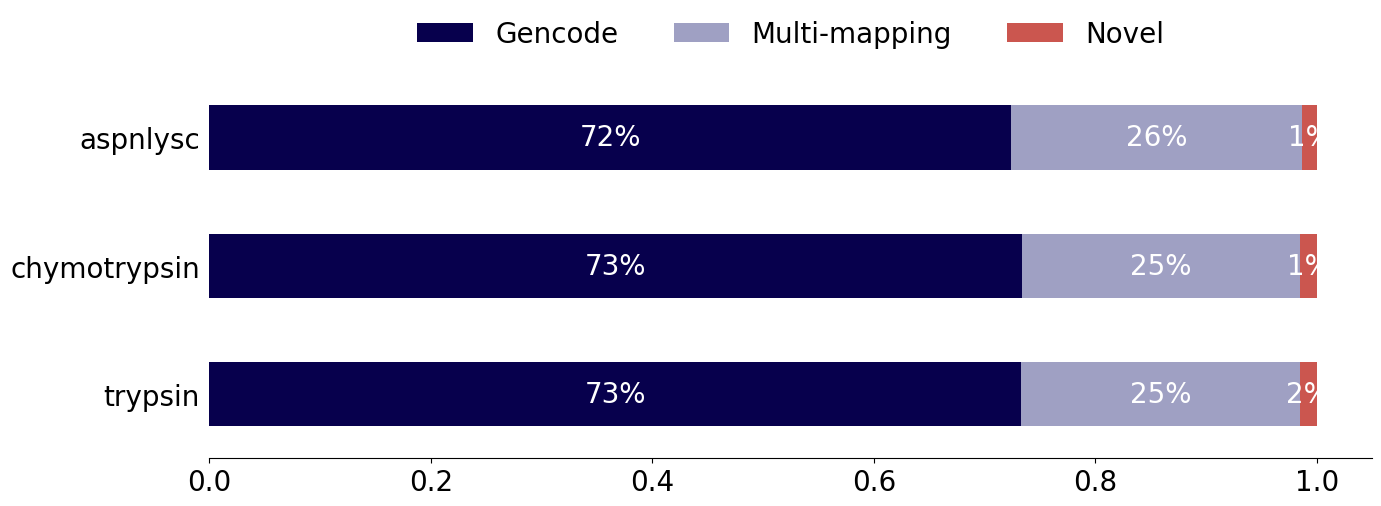

In [23]:
peptides_per_enzyme_count_df = pd.DataFrame(peptides_per_enzyme_count)
peptides_per_enzyme_count_df = peptides_per_enzyme_count_df.transpose()

# Update the figure size
rc = {'figure.figsize':(15,5)}
plt.rcParams.update(rc)

plt.rcParams["svg.fonttype"] = "none"

p = peptides_per_enzyme_count_df.plot(kind='barh', stacked=True, color= ['#07004D', '#9FA0C3','#cb564f'])

# Add data label
for c in p.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [f'{v.get_width():.0%}' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    p.bar_label(c, labels=labels, label_type='center',  color = 'white')

# Remove black x and y axis line
sns.despine(bottom = False, left = True)
# Remove y ticks
p.tick_params(left=False)
sns.move_legend(p, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,)
plt.savefig('plots/peptides_per_enzyme.svg', dpi = 300,  bbox_inches='tight')
plt.show()


# D. Comparison of ORF and transcript classification

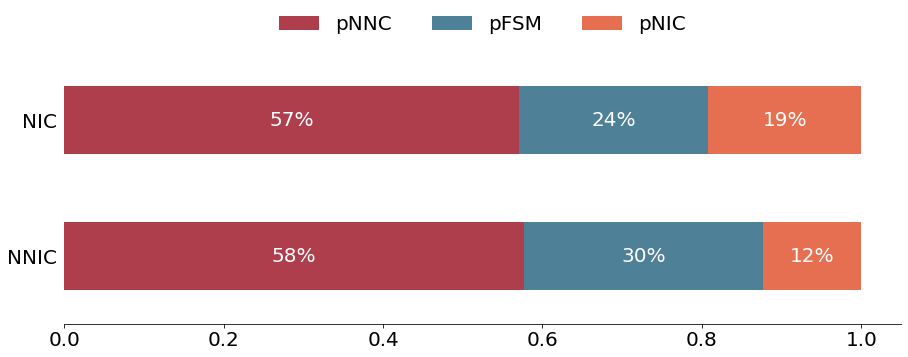

In [6]:
# Load the file with transcript and ORD classification
sqanti_protein = pd.read_csv('../data/proteomics/isoquant/hnr_50.classification_filtered.tsv', sep = '\t')

# Extract the transcript classification from the transcript name
sqanti_protein['tclass'] = [i[-1] for i in sqanti_protein.pb.str.split('.')]
transcript_class_count = {}
transcript_class_count['NNIC'] = sqanti_protein[sqanti_protein.tclass == 'NNIC'].pclass.value_counts(normalize=True)
transcript_class_count['NIC'] = sqanti_protein[sqanti_protein.tclass == 'NIC'].pclass.value_counts(normalize=True)

# Create a dataframe with the transcript counts
transcript_class_count_df = pd.DataFrame(transcript_class_count)
transcript_class_count_df = transcript_class_count_df.transpose()

# Update the figure size
rc = {'figure.figsize':(15,5)}
plt.rcParams.update(rc)

# Create a stacked barplot
p = transcript_class_count_df.plot(kind='barh', stacked=True, color=['#AF3E4D', '#4E8098', '#E76F51'])

# Add data label
for c in p.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [f'{v.get_width():.0%}' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    p.bar_label(c, labels=labels, label_type='center',  color = 'white')

# Remove black x and y axis line
sns.despine(bottom = False, left = True)
# Remove y ticks
p.tick_params(left=False)

sns.move_legend(p, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,)
plt.savefig('plots/orf_transcript_classification_percentage.svg', dpi = 300,  bbox_inches='tight')
plt.show()